# Importing necessary libraries

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# File system manangement
import os

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

# Read in the data

In [19]:
# List files available
print(os.listdir("../Logistic regression(LAB-5)/"))

['.ipynb_checkpoints', 'Logistic_Regression.ipynb', 'titanic']


In [20]:
# Training Data

train = pd.read_csv('../Logistic regression(LAB-5)/titanic/train.csv')
print('Training data shape: ', train.shape)
train.head()

Training data shape:  (891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [21]:
# Testing data features
test = pd.read_csv('../Logistic regression(LAB-5)/titanic/test.csv')
print('Testing data shape: ', test.shape)
test.head()

Testing data shape:  (418, 11)


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


# Exploratory Data Analysis(EDA)

In [22]:
train['Survived'].value_counts()

Survived
0    549
1    342
Name: count, dtype: int64

<Axes: xlabel='Survived', ylabel='count'>

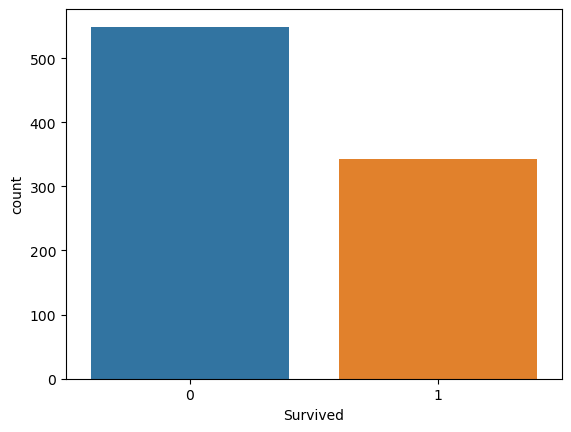

In [23]:
sns.countplot(x = 'Survived',data = train)

<Axes: xlabel='Survived', ylabel='count'>

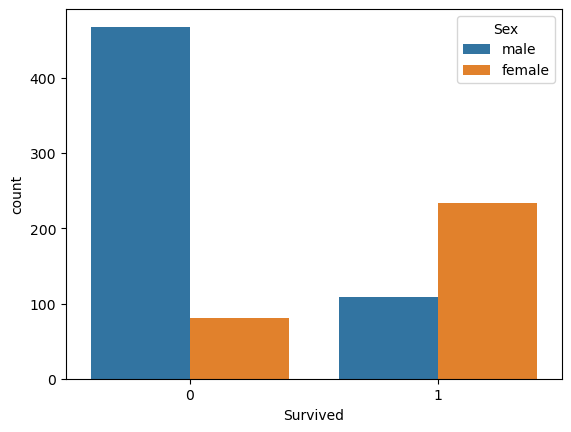

In [24]:
sns.countplot(x = 'Survived',hue = 'Sex',data = train)

AttributeError: 'numpy.int64' object has no attribute 'startswith'

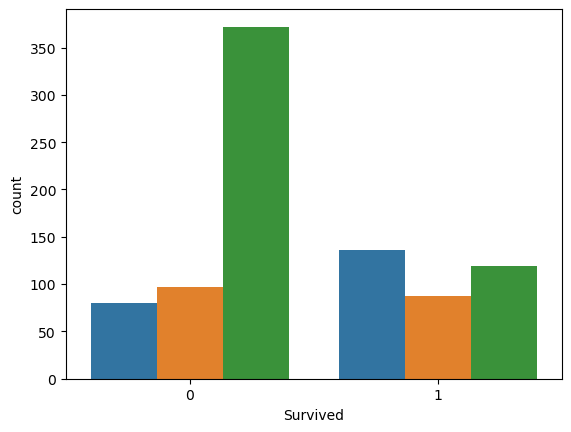

In [26]:
sns.countplot(x = 'Survived',hue = 'Pclass',data = train)

<Axes: xlabel='Pclass', ylabel='Age'>

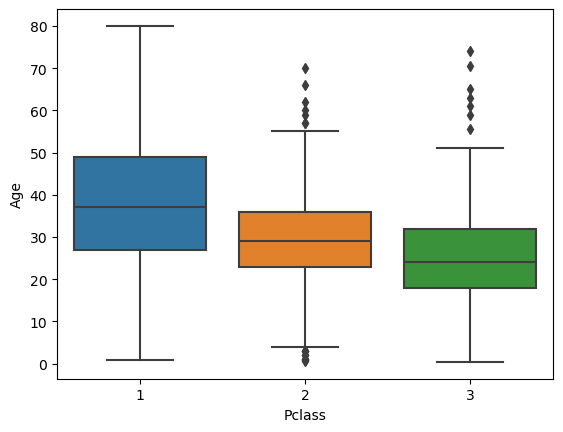

In [28]:
sns.boxplot(x='Pclass',y='Age',data=train)

# Examining Missing Values

In [29]:
print("Null in Training set")
print("---------------------")
print(train.isnull().sum())
print("---------------------")
print("Null in Testing set")
print("---------------------")
print(test.isnull().sum())

Null in Training set
---------------------
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64
---------------------
Null in Testing set
---------------------
PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


In [30]:
def add_age(cols):
    Age = cols[0]
    Pclass = cols[1]
    if pd.isnull(Age):
        return int(train[train["Pclass"] == Pclass]["Age"].mean())
    else:
        return Age

In [31]:
train['Age'] = train[['Age','Pclass']].apply(add_age,axis=1)
test['Age'] = test[['Age','Pclass']].apply(add_age,axis=1)

In [32]:
train.drop("Cabin",inplace=True,axis=1)
test.drop("Cabin",inplace=True,axis=1)

In [33]:
train['Embarked'].fillna(train['Embarked'].mode()[0],inplace=True)
test['Embarked'].fillna(test['Embarked'].mode()[0],inplace=True)

In [34]:
test['Fare'].fillna(test['Fare'].mean(),inplace=True)

In [35]:
def combine(df,col1,col2):
    df["Family"] = df[col1]+df[col2]
    df.drop([col1,col2],inplace=True,axis=1)
    return df

train = combine(train,'SibSp','Parch')
test = combine(test,'SibSp','Parch')

In [36]:
train['Age'].describe()

count    891.000000
mean      29.252716
std       13.211959
min        0.420000
25%       22.000000
50%       26.000000
75%       37.000000
max       80.000000
Name: Age, dtype: float64

<Axes: xlabel='Age_categories'>

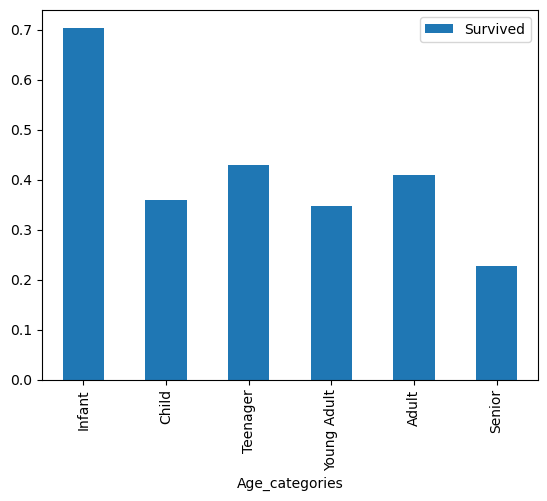

In [37]:
def process_age(df,cut_points,label_names):
    df["Age"] = df["Age"].fillna(-0.5)
    df["Age_categories"] = pd.cut(df["Age"],cut_points,labels=label_names)
    return df

cut_points = [-1,0,5,12,18,35,60,100]
label_names = ["Missing","Infant","Child","Teenager","Young Adult","Adult","Senior"]
train = process_age(train,cut_points,label_names)
test = process_age(test,cut_points,label_names)

pivot = train.pivot_table(index="Age_categories",values='Survived')
pivot.plot.bar()

# Encoding Categorical Variables

In [38]:
def create_dummies(df,column_name):
    dummies = pd.get_dummies(df[column_name],prefix=column_name)
    df = pd.concat([df,dummies],axis=1)
    return df

for column in ["Pclass","Sex","Age_categories",'Embarked']:
    train = create_dummies(train,column)
    test = create_dummies(test,column)

# Dropping Unnecessary columns

In [39]:
train.drop(['Name','Sex','Ticket','Pclass','Age_categories','Embarked'],inplace=True,axis=1)
test.drop(['Name','Sex','Ticket','Pclass','Age_categories','Embarked'],inplace=True,axis=1)

# Logistic Regression Implementation

In [40]:
lr = LogisticRegression()
columns = ['PassengerId', 'Age', 'Fare','Family',
       'Pclass_1', 'Pclass_2', 'Pclass_3', 'Sex_female', 'Sex_male',
       'Age_categories_Missing', 'Age_categories_Infant',
       'Age_categories_Child', 'Age_categories_Teenager',
       'Age_categories_Young Adult', 'Age_categories_Adult',
       'Age_categories_Senior']

lr.fit(train[columns], train["Survived"])

LogisticRegression()

# Evaluating Accuracy of our model

In [41]:
X = train[columns]
y = train['Survived']

train_X, val_X, train_y, val_y = train_test_split(
    X, y, test_size=0.20,random_state=0)

In [42]:
lr = LogisticRegression()
lr.fit(train_X, train_y)
predictions = lr.predict(val_X)
accuracy = accuracy_score(val_y, predictions)
print(accuracy)
from sklearn.metrics import classification_report
print(classification_report(val_y,predictions))

0.8268156424581006
              precision    recall  f1-score   support

           0       0.84      0.89      0.86       110
           1       0.81      0.72      0.76        69

    accuracy                           0.83       179
   macro avg       0.82      0.81      0.81       179
weighted avg       0.83      0.83      0.82       179



In [43]:
lr = LogisticRegression()
scores = cross_val_score(lr, X, y, cv=10)
scores.sort()
accuracy = scores.mean()

print(scores)
print(accuracy)

[0.7752809  0.7752809  0.79775281 0.80898876 0.82022472 0.82022472
 0.83146067 0.83146067 0.83333333 0.87640449]
0.8170411985018727


In [44]:
lr = LogisticRegression()
lr.fit(X,y)
predictions_test = lr.predict(test[columns])

# Submission

In [47]:
submission = pd.read_csv('../Logistic regression(LAB-5)/titanic/gender_submission.csv')
submission_df = pd.DataFrame({'PassengerId' : test['PassengerId'],
                              'Survived':predictions_test})
submission_df.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1


In [48]:
submission_df.to_csv("submission.csv",index=False)